In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import numpy as np

from src.modeling.run_model_single import (
    load_model, load_inputs, process_augment_inputs, batch_to_tensor
)
import src.utilities.pickling as pickling

In [30]:
shared_parameters = {
    "device_type": "gpu",
    "gpu_number": 0,
    "max_crop_noise": (100, 100),
    "max_crop_size_noise": 100,
    "batch_size": 1,
    "seed": 0,
    "augmentation": True,
    "use_hdf5": True,
}

# A. Image-Only Model

We create a dictionary containing the configuration parameters for our image-only model, and load the corresponding weights.

In [31]:
random_number_generator = np.random.RandomState(shared_parameters["seed"])

image_only_parameters = shared_parameters.copy()
image_only_parameters["view"] = "R-CC"
image_only_parameters["use_heatmaps"] = False
image_only_parameters["model_path"] = "models/ImageOnly__ModeImage_weights.p"
model, device = load_model(image_only_parameters)

We load the data for a single input instance (one `L-CC` mammogram image).

The preprocessing (e.g. cropping) must have been completed beforehand.

In [32]:
model_input = load_inputs(
    image_path="sample_single_output/cropped.png",
    metadata_path="sample_single_output/cropped_metadata.pkl",
    use_heatmaps=False,
)

We perform data augmentation if necessary, collate it into a batch of size 1, and convert it to a PyTorch tensor.

In [33]:
batch = [
    process_augment_inputs(
        model_input=model_input,
        random_number_generator=random_number_generator,
        parameters=image_only_parameters,
    ),
]
tensor_batch = batch_to_tensor(batch, device)

We can plot what the input to our model looks like.

Text(0.5, 1.0, 'Image')

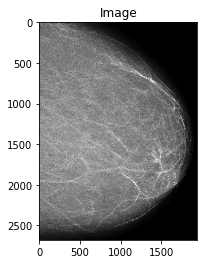

In [34]:
plt.imshow(tensor_batch[0].cpu().numpy()[0], cmap="gray");
plt.title("Image")

We run the input tensor through our model, which generates raw prediction logits.

In [35]:
y_hat = model(tensor_batch)

We convert the logits to prediction probabilities.

In [36]:
predictions = np.exp(y_hat.cpu().detach().numpy())[:, :2, 1]
predictions_dict = {
    "benign": float(predictions[0][0]),
    "malignant": float(predictions[0][1]),
}
print(predictions_dict)

{'benign': 0.02394820749759674, 'malignant': 0.007083619479089975}


(Results differ from the `run_single.sh` script because of augmentation.)

# B. Image-and-Heatmaps Model

We do the same as the above, except we create/load a model that also operates on heatmaps.

In [42]:
image_heatmaps_parameters = shared_parameters.copy()
image_heatmaps_parameters["view"] = "R-CC"
image_heatmaps_parameters["use_heatmaps"] = True
image_heatmaps_parameters["model_path"] = "models/ImageHeatmaps__ModeImage_weights.p"
model, device = load_model(image_heatmaps_parameters)

We load the image and heatmap data. As before, the heatmaps should be created beforehand.

In [43]:
model_input = load_inputs(
    image_path="sample_single_output/cropped.png",
    metadata_path="sample_single_output/cropped_metadata.pkl",
    use_heatmaps=True,
    benign_heatmap_path="sample_single_output/benign_heatmap.hdf5",
    malignant_heatmap_path="sample_single_output/malignant_heatmap.hdf5",
)

Input processing and augmentation as identical to before.

In [44]:
batch = [
    process_augment_inputs(
        model_input=model_input,
        random_number_generator=random_number_generator,
        parameters=image_heatmaps_parameters,
    ),
]
tensor_batch = batch_to_tensor(batch, device)

Text(0.5, 1.0, 'Malignant Heatmap')

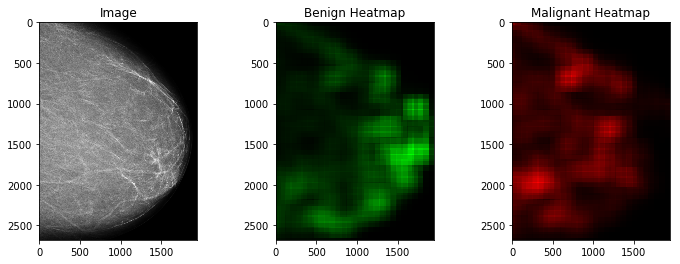

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
x = tensor_batch[0].cpu().numpy()

axes[0].imshow(x[0], cmap="gray")
axes[0].set_title("Image")

axes[1].imshow(x[1], cmap=LinearSegmentedColormap.from_list("benign", [(0, 0, 0), (0, 1, 0)]))
axes[1].set_title("Benign Heatmap")

axes[2].imshow(x[2], cmap=LinearSegmentedColormap.from_list("malignant", [(0, 0, 0), (1, 0, 0)]))
axes[2].set_title("Malignant Heatmap")

We compute the predictions the same as before

In [46]:
y_hat = model(tensor_batch)

predictions = np.exp(y_hat.cpu().detach().numpy())[:, :2, 1]
predictions_dict = {
    "benign": float(predictions[0][0]),
    "malignant": float(predictions[0][1]),
}
print(predictions_dict)

{'benign': 0.05859338864684105, 'malignant': 0.004051515832543373}
